<a href="https://colab.research.google.com/github/Jundula/ML/blob/main/Forex%20Trading%20strategy%20optimization%20with%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Preparation and Analysis


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the data (tab-separated)
data = pd.read_csv('/content/SSMT_Temporal_Analysis.csv', sep='\t')

# Inspect the data
print(f"Total signals: {len(data)}")
print(f"True signals: {data['WasDirectionalMove'].sum()} ({data['WasDirectionalMove'].mean()*100:.2f}%)")
print(f"False signals: {len(data) - data['WasDirectionalMove'].sum()}")


Total signals: 6340
True signals: 4818 (75.99%)
False signals: 1522


In [53]:
# Convert time columns to datetime
time_columns = ['SignalTime', 'QuarterHighTime', 'QuarterLowTime']
for col in time_columns:
    data[col] = pd.to_datetime(data[col])

# Create cyclical features for day of week and hour
# This handles the circular nature of time better
for col in ['QuarterHighDayOfWeek', 'QuarterLowDayOfWeek', 'SignalDayOfWeek']:
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col] / 7)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col] / 7)

for col in ['QuarterHighHour', 'QuarterLowHour', 'SignalHour']:
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col] / 24)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col] / 24)

# Split by signal type to analyze BUY and SELL signals separately
buy_signals = data[data['SignalType'] == 'BUY']
sell_signals = data[data['SignalType'] == 'SELL']

print(f"BUY signals: {len(buy_signals)} (Success rate: {buy_signals['WasDirectionalMove'].mean()*100:.2f}%)")
print(f"SELL signals: {len(sell_signals)} (Success rate: {sell_signals['WasDirectionalMove'].mean()*100:.2f}%)")


BUY signals: 3140 (Success rate: 75.32%)
SELL signals: 3200 (Success rate: 76.66%)


([<matplotlib.axis.XTick at 0x7ea3c30247d0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

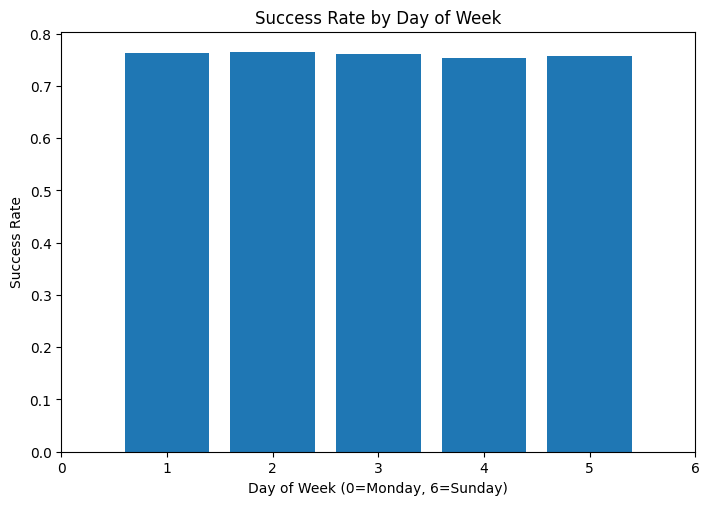

In [54]:
# Visualize success rates by temporal features
plt.figure(figsize=(18, 12))
# Day of week success rates
plt.subplot(2, 2, 1)
dow_success = data.groupby('SignalDayOfWeek')['WasDirectionalMove'].mean()
plt.bar(dow_success.index, dow_success.values)
plt.title('Success Rate by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Success Rate')
plt.xticks(range(7))

([<matplotlib.axis.XTick at 0x7ea3c2ecf710>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22')])

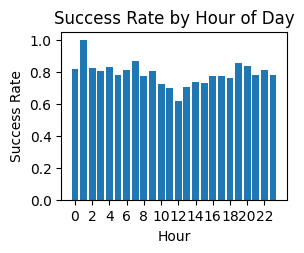

In [55]:
# Hour of day success rates
plt.subplot(2, 2, 2)
hour_success = data.groupby('SignalHour')['WasDirectionalMove'].mean()
plt.bar(hour_success.index, hour_success.values)
plt.title('Success Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Success Rate')
plt.xticks(range(0, 24, 2))

<ipython-input-56-8d57184c4ffd>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_success = data.groupby('DaysHighBin')['WasDirectionalMove'].mean()


Text(0, 0.5, 'Success Rate')

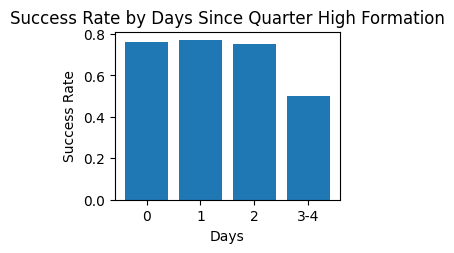

In [56]:
# Days since high formation
plt.subplot(2, 2, 3)
days_high_bins = [0, 1, 2, 3, 5, 10, 99]
days_high_labels = ['0', '1', '2', '3-4', '5-9', '10+']
data['DaysHighBin'] = pd.cut(data['DaysSinceHighFormation'], bins=days_high_bins, labels=days_high_labels)
high_success = data.groupby('DaysHighBin')['WasDirectionalMove'].mean()
plt.bar(high_success.index, high_success.values)
plt.title('Success Rate by Days Since Quarter High Formation')
plt.xlabel('Days')
plt.ylabel('Success Rate')

<ipython-input-57-bfe5b482f488>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low_success = data.groupby('DaysLowBin')['WasDirectionalMove'].mean()


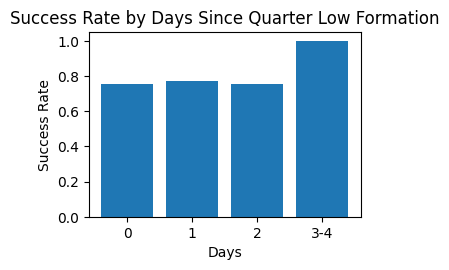

In [57]:
# Days since low formation
plt.subplot(2, 2, 4)
days_low_bins = [0, 1, 2, 3, 5, 10, 99]
days_low_labels = ['0', '1', '2', '3-4', '5-9', '10+']
data['DaysLowBin'] = pd.cut(data['DaysSinceLowFormation'], bins=days_low_bins, labels=days_low_labels)
low_success = data.groupby('DaysLowBin')['WasDirectionalMove'].mean()
plt.bar(low_success.index, low_success.values)
plt.title('Success Rate by Days Since Quarter Low Formation')
plt.xlabel('Days')
plt.ylabel('Success Rate')

plt.tight_layout()
plt.savefig('temporal_success_rates.png')
plt.show()

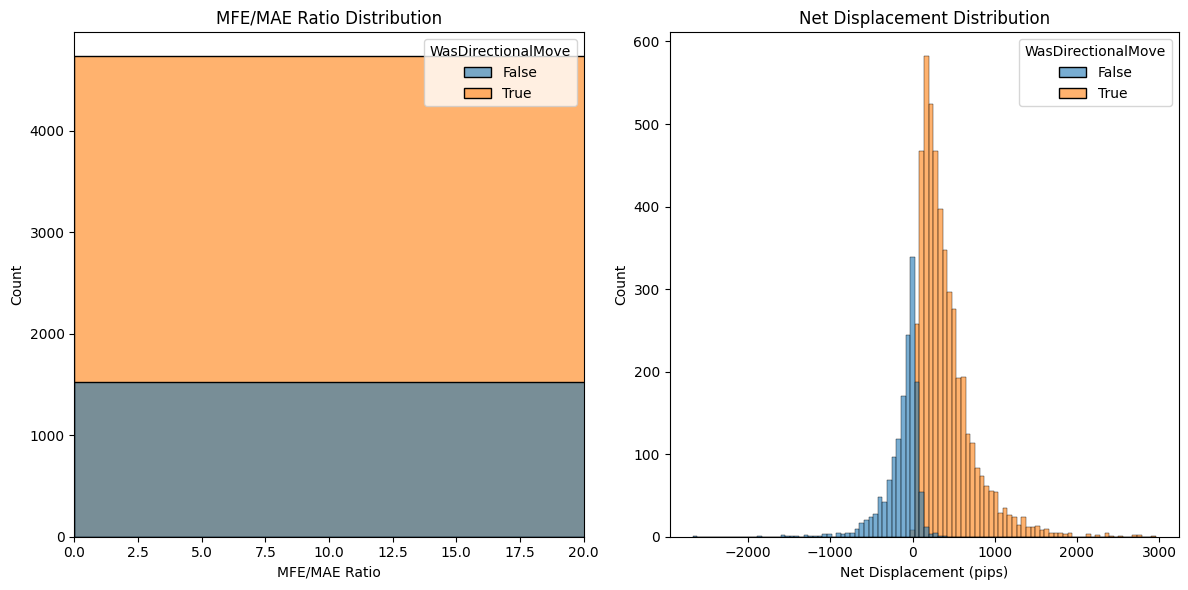

In [58]:
# Analyze MFE/MAE ratio distribution
data['MFE_MAE_Ratio'] = data['MaxFavorableExcursion'] / data['MaxAdverseExcursion'].replace(0, 0.1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='MFE_MAE_Ratio', hue='WasDirectionalMove', bins=20, alpha=0.6)
plt.title('MFE/MAE Ratio Distribution')
plt.xlabel('MFE/MAE Ratio')
plt.xlim(0, 20)  # Limit to reasonable range

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='NetDisplacement', hue='WasDirectionalMove', bins=100, alpha=0.6)
plt.title('Net Displacement Distribution')
plt.xlabel('Net Displacement (pips)')

plt.tight_layout()
plt.savefig('displacement_analysis.png')
plt.show()

In [59]:
# Select features for the model
features = [
    # Temporal features
    'DaysSinceHighFormation', 'DaysSinceLowFormation',
    'HoursSinceHighFormation', 'HoursSinceLowFormation',

    # Cyclical time features
    'QuarterHighDayOfWeek_sin', 'QuarterHighDayOfWeek_cos',
    'QuarterHighHour_sin', 'QuarterHighHour_cos',
    'QuarterLowDayOfWeek_sin', 'QuarterLowDayOfWeek_cos',
    'QuarterLowHour_sin', 'QuarterLowHour_cos',
    'SignalDayOfWeek_sin', 'SignalDayOfWeek_cos',
    'SignalHour_sin', 'SignalHour_cos',

    # Price relationship features
    'PriceToQuarterHighRatio', 'PriceToQuarterLowRatio',
    'QuarterProgressPercent',

    # Other
    'PSPConfirmed'
]

# Prepare data for modeling
X = data[features]
y = data['WasDirectionalMove']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Train multiple models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [60]:
# Evaluate models
results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': model.score(X_test, y_test),
        'predictions': y_pred,
        'probabilities': model.predict_proba(X_test)[:, 1]
    }

    # Print classification report
    print(f"\n{name} Test Results:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print(f"True Positives: {cm[1][1]}, False Positives: {cm[0][1]}")
    print(f"True Negatives: {cm[0][0]}, False Negatives: {cm[1][0]}")
    print("-------------------------------------------")

Logistic Regression CV Accuracy: 0.7598 ± 0.0018

Logistic Regression Test Results:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       457
        True       0.76      1.00      0.86      1445

    accuracy                           0.76      1902
   macro avg       0.38      0.50      0.43      1902
weighted avg       0.58      0.76      0.66      1902

Confusion Matrix:
[[   0  457]
 [   0 1445]]
True Positives: 1445, False Positives: 457
True Negatives: 0, False Negatives: 0
-------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest CV Accuracy: 0.7650 ± 0.0126

Random Forest Test Results:
              precision    recall  f1-score   support

       False       0.56      0.25      0.35       457
        True       0.80      0.94      0.86      1445

    accuracy                           0.77      1902
   macro avg       0.68      0.59      0.60      1902
weighted avg       0.74      0.77      0.74      1902

Confusion Matrix:
[[ 115  342]
 [  90 1355]]
True Positives: 1355, False Positives: 342
True Negatives: 115, False Negatives: 90
-------------------------------------------
Gradient Boosting CV Accuracy: 0.7711 ± 0.0131

Gradient Boosting Test Results:
              precision    recall  f1-score   support

       False       0.57      0.23      0.33       457
        True       0.80      0.95      0.86      1445

    accuracy                           0.77      1902
   macro avg       0.68      0.59      0.60      1902
weighted avg       0.74      0.77      0.74      1902

Confusion Matrix:
[[ 

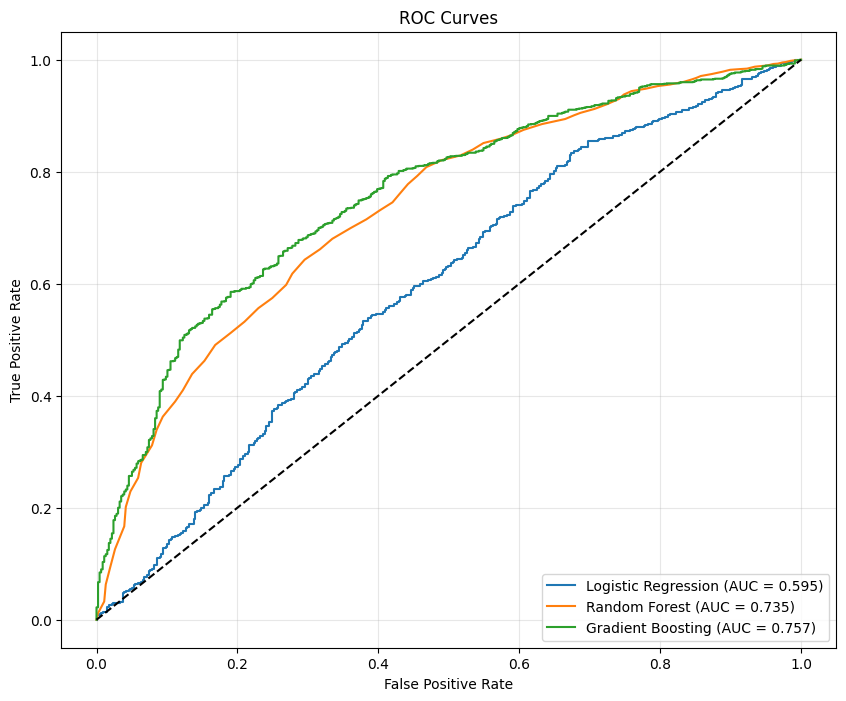

<Figure size 1000x800 with 0 Axes>

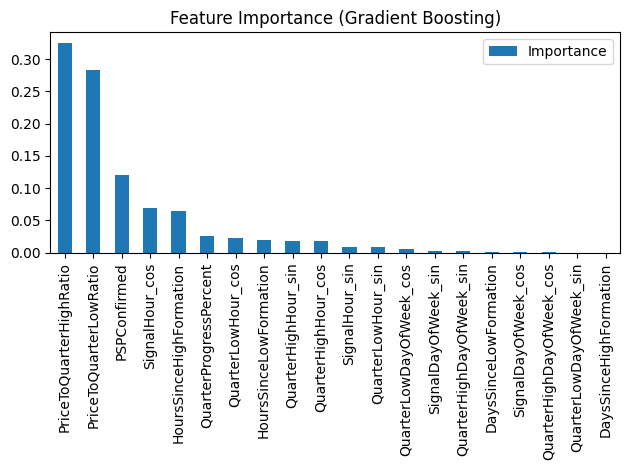

In [61]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png')
plt.show()

# Feature importance analysis (using the best model)
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

if best_model_name == 'Logistic Regression':
    # For logistic regression, look at coefficients
    coefs = pd.DataFrame(
        best_model.coef_[0],
        index=features,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(10, 8))
    coefs.plot(kind='bar')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Print coefficients for implementation in MQL5
    print("\nLogistic Regression Coefficients for MQL5 Implementation:")
    print(f"double modelIntercept = {best_model.intercept_[0]:.6f};")
    print("double modelCoefficients[] = {")
    for i, feature in enumerate(features):
        comma = "," if i < len(features) - 1 else ""
        print(f"    {best_model.coef_[0][i]:.6f}{comma}  // {feature}")
    print("};")

elif best_model_name in ['Random Forest', 'Gradient Boosting']:
    # For tree-based models, look at feature importance
    importances = pd.DataFrame(
        best_model.feature_importances_,
        index=features,
        columns=['Importance']
    ).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    importances.plot(kind='bar')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

In [62]:
# Probability threshold analysis
if best_model_name == 'Logistic Regression':
    # Try different probability thresholds
    thresholds = np.arange(0.4, 0.81, 0.05)
    threshold_results = []

    for threshold in thresholds:
        y_pred_t = (results[best_model_name]['probabilities'] >= threshold).astype(int)
        true_signals = y_pred_t.sum()
        correct_signals = (y_pred_t & y_test.values).sum()

        if true_signals > 0:
            precision = correct_signals / true_signals
        else:
            precision = 0

        threshold_results.append({
            'Threshold': threshold,
            'Signals Taken': true_signals,
            'Correct Signals': correct_signals,
            'Precision': precision,
            'Signal Reduction': 1 - (true_signals / len(y_test))
        })

    threshold_df = pd.DataFrame(threshold_results)
    print("\nProbability Threshold Analysis:")
    print(threshold_df)

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'o-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Signal Reduction'], 'o-', label='Signal Reduction')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Value')
    plt.title('Precision vs. Signal Reduction by Threshold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('threshold_analysis.png')
    plt.show()

In [63]:
threshold_results

[{'Threshold': 0.4,
  'Signals Taken': 670,
  'Correct Signals': 532,
  'Precision': 0.7940298507462686,
  'Signal Reduction': 0.048295454545454586},
 {'Threshold': 0.45,
  'Signals Taken': 654,
  'Correct Signals': 527,
  'Precision': 0.8058103975535168,
  'Signal Reduction': 0.07102272727272729},
 {'Threshold': 0.5,
  'Signals Taken': 639,
  'Correct Signals': 518,
  'Precision': 0.810641627543036,
  'Signal Reduction': 0.09232954545454541},
 {'Threshold': 0.55,
  'Signals Taken': 613,
  'Correct Signals': 502,
  'Precision': 0.8189233278955954,
  'Signal Reduction': 0.12926136363636365},
 {'Threshold': 0.6,
  'Signals Taken': 573,
  'Correct Signals': 477,
  'Precision': 0.8324607329842932,
  'Signal Reduction': 0.18607954545454541},
 {'Threshold': 0.6499999999999999,
  'Signals Taken': 527,
  'Correct Signals': 447,
  'Precision': 0.8481973434535104,
  'Signal Reduction': 0.2514204545454546},
 {'Threshold': 0.7,
  'Signals Taken': 485,
  'Correct Signals': 418,
  'Precision': 0.861

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Import advanced models
try:
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    has_advanced_models = True
except ImportError:
    has_advanced_models = False
    print("XGBoost and/or LightGBM not installed. Run: pip install xgboost lightgbm")

# Load the data (tab-separated)
data = pd.read_csv('/content/SSMT_Temporal_Analysis.csv', sep='\t')

# Inspect the data
print(f"Total signals: {len(data)}")
print(f"True signals: {data['WasDirectionalMove'].sum()} ({data['WasDirectionalMove'].mean()*100:.2f}%)")
print(f"False signals: {len(data) - data['WasDirectionalMove'].sum()}")

Total signals: 6340
True signals: 4818 (75.99%)
False signals: 1522


In [65]:
# Convert time columns to datetime
time_columns = ['SignalTime', 'QuarterHighTime', 'QuarterLowTime']
for col in time_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col])

# Create cyclical features for day of week and hour
# This handles the circular nature of time better
for col in ['QuarterHighDayOfWeek', 'QuarterLowDayOfWeek', 'SignalDayOfWeek']:
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col] / 7)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col] / 7)

for col in ['QuarterHighHour', 'QuarterLowHour', 'SignalHour']:
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col] / 24)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col] / 24)

# Create additional engineered features
print("Creating additional features...")

# Time difference features
data['HighLow_TimeDiff'] = abs(data['HoursSinceHighFormation'] - data['HoursSinceLowFormation'])

# Price relationship features
data['PriceRatio_Product'] = data['PriceToQuarterHighRatio'] * data['PriceToQuarterLowRatio']
data['PriceRatio_Diff'] = abs(data['PriceToQuarterHighRatio'] - data['PriceToQuarterLowRatio'])

# Historical success rates by time segment (using cross-validation to avoid data leakage)
data['HourSuccess'] = data.groupby('SignalHour')['WasDirectionalMove'].transform('mean')
data['DaySuccess'] = data.groupby('SignalDayOfWeek')['WasDirectionalMove'].transform('mean')

# Split by signal type to analyze BUY and SELL signals separately
buy_signals = data[data['SignalType'] == 'BUY']
sell_signals = data[data['SignalType'] == 'SELL']

print(f"BUY signals: {len(buy_signals)} (Success rate: {buy_signals['WasDirectionalMove'].mean()*100:.2f}%)")
print(f"SELL signals: {len(sell_signals)} (Success rate: {sell_signals['WasDirectionalMove'].mean()*100:.2f}%)")


Creating additional features...
BUY signals: 3140 (Success rate: 75.32%)
SELL signals: 3200 (Success rate: 76.66%)


([<matplotlib.axis.XTick at 0x7ea39ef8d690>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

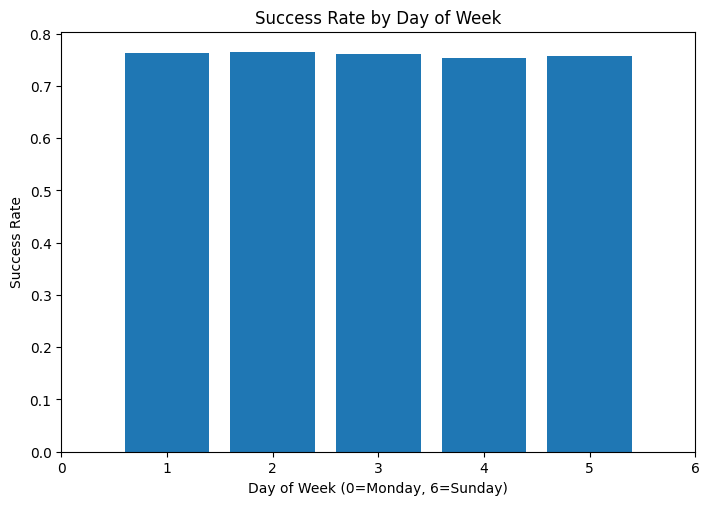

In [66]:
# Visualize success rates by temporal features
plt.figure(figsize=(18, 12))
# Day of week success rates
plt.subplot(2, 2, 1)
dow_success = data.groupby('SignalDayOfWeek')['WasDirectionalMove'].mean()
plt.bar(dow_success.index, dow_success.values)
plt.title('Success Rate by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Success Rate')
plt.xticks(range(7))

([<matplotlib.axis.XTick at 0x7ea39eb2fbd0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22')])

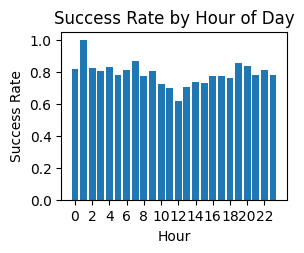

In [67]:
# Hour of day success rates
plt.subplot(2, 2, 2)
hour_success = data.groupby('SignalHour')['WasDirectionalMove'].mean()
plt.bar(hour_success.index, hour_success.values)
plt.title('Success Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Success Rate')
plt.xticks(range(0, 24, 2))

<ipython-input-68-8d57184c4ffd>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_success = data.groupby('DaysHighBin')['WasDirectionalMove'].mean()


Text(0, 0.5, 'Success Rate')

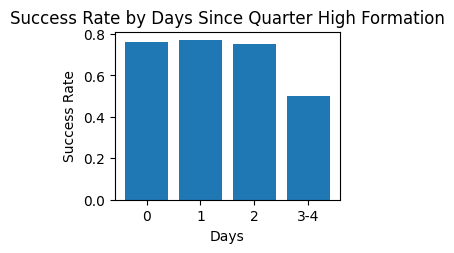

In [68]:
# Days since high formation
plt.subplot(2, 2, 3)
days_high_bins = [0, 1, 2, 3, 5, 10, 99]
days_high_labels = ['0', '1', '2', '3-4', '5-9', '10+']
data['DaysHighBin'] = pd.cut(data['DaysSinceHighFormation'], bins=days_high_bins, labels=days_high_labels)
high_success = data.groupby('DaysHighBin')['WasDirectionalMove'].mean()
plt.bar(high_success.index, high_success.values)
plt.title('Success Rate by Days Since Quarter High Formation')
plt.xlabel('Days')
plt.ylabel('Success Rate')

<ipython-input-69-135a792e117a>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_hours_success = data.groupby('HoursSinceHighBin')['WasDirectionalMove'].mean()


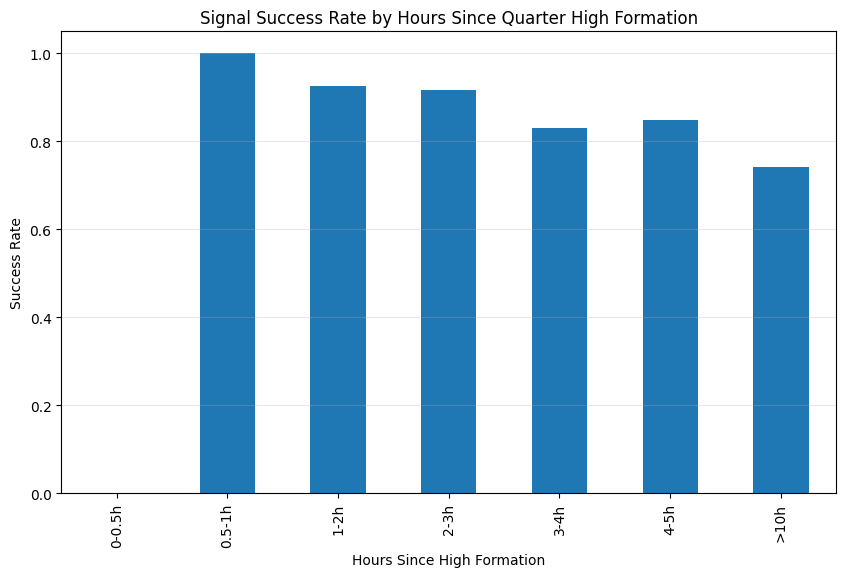

In [69]:
# Group by hours since high formation (binned) and calculate success rate
hours_bins = [0, 0.5, 1, 2, 3, 4, 5, 10]  # 0-6h, 6-12h, 12-24h, 1-2d, 2-3d, 3-7d, >7d
hours_labels = ['0-0.5h', '0.5-1h', '1-2h', '2-3h', '3-4h', '4-5h', '>10h']

data['HoursSinceHighBin'] = pd.cut(data['HoursSinceHighFormation'], bins=hours_bins, labels=hours_labels)
high_hours_success = data.groupby('HoursSinceHighBin')['WasDirectionalMove'].mean()

plt.figure(figsize=(10, 6))
high_hours_success.plot(kind='bar')
plt.title('Signal Success Rate by Hours Since Quarter High Formation')
plt.xlabel('Hours Since High Formation')
plt.ylabel('Success Rate')
plt.grid(axis='y', alpha=0.3)
plt.show()

<ipython-input-70-bfe5b482f488>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low_success = data.groupby('DaysLowBin')['WasDirectionalMove'].mean()


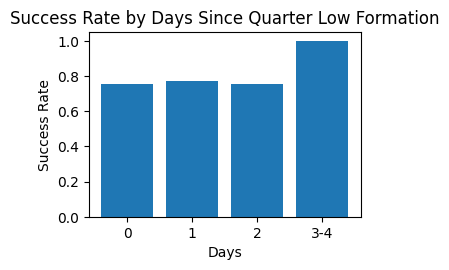

In [70]:
# Days since low formation
plt.subplot(2, 2, 4)
days_low_bins = [0, 1, 2, 3, 5, 10, 99]
days_low_labels = ['0', '1', '2', '3-4', '5-9', '10+']
data['DaysLowBin'] = pd.cut(data['DaysSinceLowFormation'], bins=days_low_bins, labels=days_low_labels)
low_success = data.groupby('DaysLowBin')['WasDirectionalMove'].mean()
plt.bar(low_success.index, low_success.values)
plt.title('Success Rate by Days Since Quarter Low Formation')
plt.xlabel('Days')
plt.ylabel('Success Rate')

plt.tight_layout()
plt.savefig('temporal_success_rates.png')
plt.show()


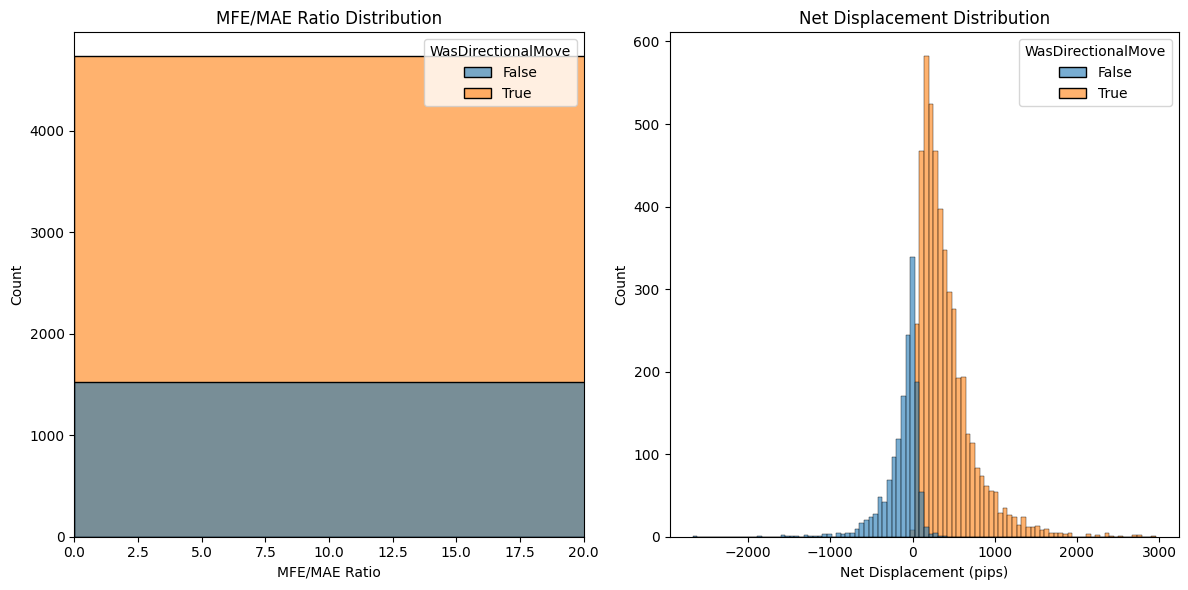

In [71]:
# Analyze metrics distributions
try:
    # MFE/MAE ratio (protect against division by zero)
    data['MFE_MAE_Ratio'] = data['MaxFavorableExcursion'] / data['MaxAdverseExcursion'].replace(0, 0.1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x='MFE_MAE_Ratio', hue='WasDirectionalMove', bins=20, alpha=0.6)
    plt.title('MFE/MAE Ratio Distribution')
    plt.xlabel('MFE/MAE Ratio')
    plt.xlim(0, 20)  # Limit to reasonable range

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x='NetDisplacement', hue='WasDirectionalMove', bins=100, alpha=0.6)
    plt.title('Net Displacement Distribution')
    plt.xlabel('Net Displacement (pips)')

    plt.tight_layout()
    plt.savefig('displacement_analysis.png')
    plt.show()
except Exception as e:
    print(f"Error generating displacement analysis plots: {e}")

In [40]:
# Select features for the model
base_features = [
    # Temporal features
    'DaysSinceHighFormation', 'DaysSinceLowFormation',
    'HoursSinceHighFormation', 'HoursSinceLowFormation',

    # Cyclical time features
    'QuarterHighDayOfWeek_sin', 'QuarterHighDayOfWeek_cos',
    'QuarterHighHour_sin', 'QuarterHighHour_cos',
    'QuarterLowDayOfWeek_sin', 'QuarterLowDayOfWeek_cos',
    'QuarterLowHour_sin', 'QuarterLowHour_cos',
    'SignalDayOfWeek_sin', 'SignalDayOfWeek_cos',
    'SignalHour_sin', 'SignalHour_cos',

    # Price relationship features
    'PriceToQuarterHighRatio', 'PriceToQuarterLowRatio',
    'QuarterProgressPercent',
]

# Add engineered features
engineered_features = [
    'HighLow_TimeDiff',
    'PriceRatio_Product',
    'PriceRatio_Diff',
    'HourSuccess',
    'DaySuccess'
]

# PSP feature if available
if 'PSPConfirmed' in data.columns:
    base_features.append('PSPConfirmed')

# Combine all features
all_features = base_features + engineered_features

# Ensure all features exist in the dataset
features = [f for f in all_features if f in data.columns]
print(f"Using {len(features)} features: {features}")

Using 25 features: ['DaysSinceHighFormation', 'DaysSinceLowFormation', 'HoursSinceHighFormation', 'HoursSinceLowFormation', 'QuarterHighDayOfWeek_sin', 'QuarterHighDayOfWeek_cos', 'QuarterHighHour_sin', 'QuarterHighHour_cos', 'QuarterLowDayOfWeek_sin', 'QuarterLowDayOfWeek_cos', 'QuarterLowHour_sin', 'QuarterLowHour_cos', 'SignalDayOfWeek_sin', 'SignalDayOfWeek_cos', 'SignalHour_sin', 'SignalHour_cos', 'PriceToQuarterHighRatio', 'PriceToQuarterLowRatio', 'QuarterProgressPercent', 'PSPConfirmed', 'HighLow_TimeDiff', 'PriceRatio_Product', 'PriceRatio_Diff', 'HourSuccess', 'DaySuccess']


In [41]:
# Prepare data for modeling
X = data[features]
y = data['WasDirectionalMove']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 1640 samples
Testing set: 704 samples


In [42]:
# Define all models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=1000,
        random_state=42
    )
}

# Add advanced models if available
if has_advanced_models:
    models.update({
        'XGBoost': XGBClassifier(
            learning_rate=0.1,
            n_estimators=100,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            random_state=42
        ),
        'LightGBM': LGBMClassifier(
            learning_rate=0.1,
            n_estimators=100,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
    })

# Train and evaluate each model
results = {}
best_auc = 0
best_model_name = ""

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"{name} CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    except Exception as e:
        print(f"Error during cross-validation: {e}")
        cv_scores = np.array([0])

    # Train on full training set
    model.fit(X_train, y_train)

    # Evaluate on test set
    try:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = (y_pred == y_test).mean()
        try:
            auc_score = roc_auc_score(y_test, y_prob)
        except Exception:
            auc_score = 0

        # Store results
        results[name] = {
            'model': model,
            'cv_auc': cv_scores.mean(),
            'test_accuracy': accuracy,
            'test_auc': auc_score,
            'predictions': y_pred,
            'probabilities': y_prob
        }

        # Print classification report
        print(f"\n{name} Test Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC: {auc_score:.4f}")
        print(classification_report(y_test, y_pred))

        # Print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)
        print(f"True Positives: {cm[1][1]}, False Positives: {cm[0][1]}")
        print(f"True Negatives: {cm[0][0]}, False Negatives: {cm[1][0]}")

        # Track best model
        if auc_score > best_auc:
            best_auc = auc_score
            best_model_name = name

    except Exception as e:
        print(f"Error evaluating model: {e}")


Training Logistic Regression...
Logistic Regression CV ROC-AUC: 0.6531 ± 0.0131

Logistic Regression Test Results:
Accuracy: 0.7713
ROC AUC: 0.6565
              precision    recall  f1-score   support

       False       0.47      0.06      0.10       160
        True       0.78      0.98      0.87       544

    accuracy                           0.77       704
   macro avg       0.63      0.52      0.48       704
weighted avg       0.71      0.77      0.69       704

Confusion Matrix:
[[  9 151]
 [ 10 534]]
True Positives: 534, False Positives: 151
True Negatives: 9, False Negatives: 10

Training Random Forest...
Random Forest CV ROC-AUC: 0.7384 ± 0.0173

Random Forest Test Results:
Accuracy: 0.8011
ROC AUC: 0.7162
              precision    recall  f1-score   support

       False       0.69      0.23      0.35       160
        True       0.81      0.97      0.88       544

    accuracy                           0.80       704
   macro avg       0.75      0.60      0.61       704

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1014, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772866 -> initscore=1.224565
[LightGBM] [Info] Start training from score 1.224565
[LightGBM] [Info] Number of positive: 1014, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772866 -> initscore=1.224565
[LightGBM] [Info] Start training from score 1.224565


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1015, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773628 -> initscore=1.228912
[LightGBM] [Info] Start training from score 1.228912
[LightGBM] [Info] Number of positive: 1015, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM CV ROC-AUC: 0.7490 ± 0.0084
[LightGBM] [Info] Number of positive: 1268, number of negative: 372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 1640, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773171 -> initscore=1.226302
[LightGBM] [Info] Start training from score 1.226302

LightGBM Test Results:
Accuracy: 0.7741
ROC AUC: 0.7275
              precision    recall  f1-score   support

       False       0.51      0.28      0.36       160
        True       0.81      0.92      0.86       544

    accuracy                           0.77       704
   macro avg       0.66      0.60      0.61       704
weighted avg       0.74      0.77      0.75       704

Confusion Matrix:
[[ 45 115]
 [ 44 500]]
True Positives: 500, False Positives: 115
True Neg

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
# Create stacked ensemble if we have at least 2 models
if len(models) >= 2 and has_advanced_models:
    print("\nTraining Stacked Ensemble...")

    # Select base models (excluding Neural Network which can be unstable)
    base_models = []
    for name, model in models.items():
        if name not in ['Neural Network']:
            base_models.append((name, model.__class__(**model.get_params())))

    # Create stacked model
    stacked_model = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(),
        cv=5
    )

    # Train stacked model
    stacked_model.fit(X_train, y_train)

    # Evaluate stacked model
    try:
        y_pred_stacked = stacked_model.predict(X_test)
        y_prob_stacked = stacked_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy_stacked = (y_pred_stacked == y_test).mean()
        auc_stacked = roc_auc_score(y_test, y_prob_stacked)

        # Store results
        results['Stacked Ensemble'] = {
            'model': stacked_model,
            'cv_auc': 0,  # CV is built into the stacking process
            'test_accuracy': accuracy_stacked,
            'test_auc': auc_stacked,
            'predictions': y_pred_stacked,
            'probabilities': y_prob_stacked
        }

        # Print classification report
        print("\nStacked Ensemble Test Results:")
        print(f"Accuracy: {accuracy_stacked:.4f}")
        print(f"ROC AUC: {auc_stacked:.4f}")
        print(classification_report(y_test, y_pred_stacked))

        # Check if stacked model is best
        if auc_stacked > best_auc:
            best_auc = auc_stacked
            best_model_name = 'Stacked Ensemble'
    except Exception as e:
        print(f"Error evaluating stacked model: {e}")



Training Stacked Ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1268, number of negative: 372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 1640, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773171 -> initscore=1.226302
[LightGBM] [Info] Start training from score 1.226302


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1014, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772866 -> initscore=1.224565
[LightGBM] [Info] Start training from score 1.224565
[LightGBM] [Info] Number of positive: 1014, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772866 -> initscore=1.224565
[LightGBM] [I

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1014, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772866 -> initscore=1.224565
[LightGBM] [Info] Start training from score 1.224565
[LightGBM] [Info] Number of positive: 1015, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773628 -> initscore=1.228912
[LightGBM] [I

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1015, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773628 -> initscore=1.228912
[LightGBM] [Info] Start training from score 1.228912

Stacked Ensemble Test Results:
Accuracy: 0.7969
ROC AUC: 0.7418
              precision    recall  f1-score   support

       False       0.65      0.23      0.34       160
        True       0.81      0.96      0.88       544

    accuracy                           0.80       704
   macro avg       0.73      0.60      0.61       704
weighted avg       0.77      0.80      0.76       704



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


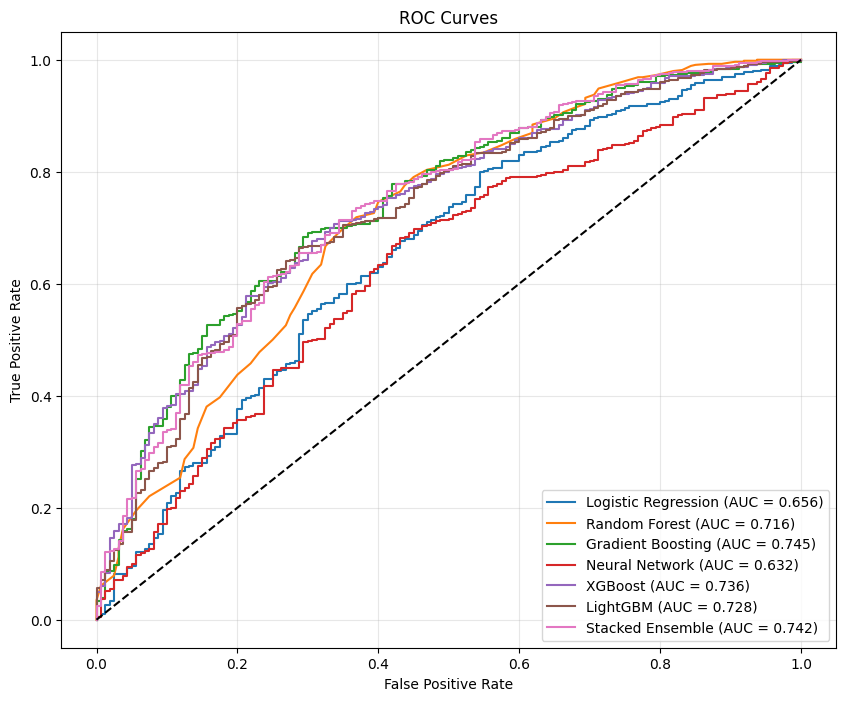


Best model: Gradient Boosting with AUC = 0.745


In [44]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    try:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        roc_auc = result['test_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    except Exception:
        pass

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png')
plt.show()

print(f"\nBest model: {best_model_name} with AUC = {best_auc:.3f}")

<Figure size 1200x800 with 0 Axes>

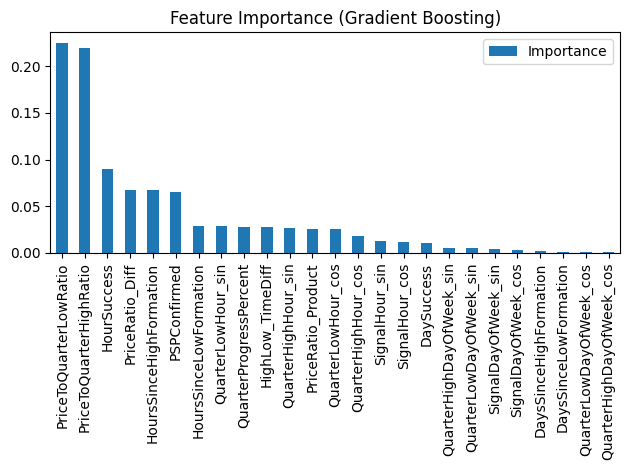


Top 10 Important Features:
                         Importance
PriceToQuarterLowRatio     0.225183
PriceToQuarterHighRatio    0.219572
HourSuccess                0.089943
PriceRatio_Diff            0.067789
HoursSinceHighFormation    0.067767
PSPConfirmed               0.065271
HoursSinceLowFormation     0.028520
QuarterLowHour_sin         0.028315
QuarterProgressPercent     0.028058
HighLow_TimeDiff           0.027627


In [45]:
# Feature importance analysis for the best model
best_model = results[best_model_name]['model']

# Different approaches based on model type
if hasattr(best_model, 'coef_'):  # Linear models
    # For logistic regression, look at coefficients
    coefs = pd.DataFrame(
        best_model.coef_[0],
        index=features,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(12, 8))
    coefs.plot(kind='bar')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Print coefficients for implementation in MQL5
    print("\nLogistic Regression Coefficients for MQL5 Implementation:")
    print(f"double modelIntercept = {best_model.intercept_[0]:.6f};")
    print("double modelCoefficients[] = {")
    for i, feature in enumerate(features):
        comma = "," if i < len(features) - 1 else ""
        print(f"    {best_model.coef_[0][i]:.6f}{comma}  // {feature}")
    print("};")

elif hasattr(best_model, 'feature_importances_'):  # Tree-based models
    # For tree-based models, look at feature importance
    importances = pd.DataFrame(
        best_model.feature_importances_,
        index=features,
        columns=['Importance']
    ).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    importances.plot(kind='bar')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Print top features
    print("\nTop 10 Important Features:")
    print(importances.head(10))
elif 'Stacked' in best_model_name:
    print("\nStacked model - individual feature importances not directly available")
else:
    print("\nFeature importance visualization not supported for this model type")



Probability Threshold Analysis:
   Threshold  Signals Taken  Correct Signals  Precision  Signal Reduction
0       0.40            670              532   0.794030          0.048295
1       0.45            654              527   0.805810          0.071023
2       0.50            639              518   0.810642          0.092330
3       0.55            613              502   0.818923          0.129261
4       0.60            573              477   0.832461          0.186080
5       0.65            527              447   0.848197          0.251420
6       0.70            485              418   0.861856          0.311080
7       0.75            446              384   0.860987          0.366477
8       0.80            392              347   0.885204          0.443182


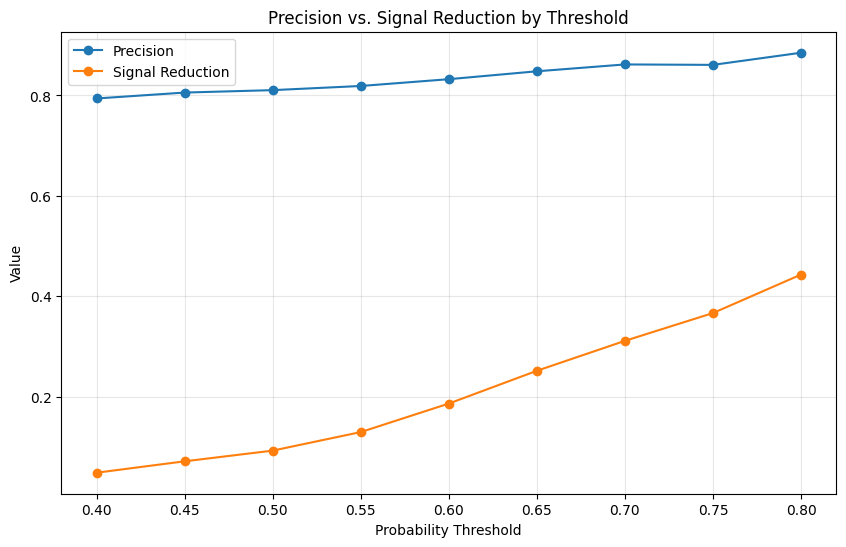

In [46]:
# Probability threshold analysis
if best_model_name != "":
    # Try different probability thresholds
    thresholds = np.arange(0.4, 0.81, 0.05)
    threshold_results = []

    for threshold in thresholds:
        y_pred_t = (results[best_model_name]['probabilities'] >= threshold).astype(int)
        true_signals = y_pred_t.sum()
        correct_signals = (y_pred_t & y_test.values).sum()

        if true_signals > 0:
            precision = correct_signals / true_signals
        else:
            precision = 0

        threshold_results.append({
            'Threshold': threshold,
            'Signals Taken': true_signals,
            'Correct Signals': correct_signals,
            'Precision': precision,
            'Signal Reduction': 1 - (true_signals / len(y_test))
        })

    threshold_df = pd.DataFrame(threshold_results)
    print("\nProbability Threshold Analysis:")
    print(threshold_df)

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'o-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Signal Reduction'], 'o-', label='Signal Reduction')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Value')
    plt.title('Precision vs. Signal Reduction by Threshold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('threshold_analysis.png')
    plt.show()


In [47]:
# Separate models for BUY and SELL signals
if len(buy_signals) > 30 and len(sell_signals) > 30:  # Ensure enough data for each
    print("\n===== Training Separate Models for BUY and SELL Signals =====")


===== Training Separate Models for BUY and SELL Signals =====


In [50]:
# Process BUY signals
X_buy = buy_signals[features]
y_buy = buy_signals['WasDirectionalMove']
X_buy_scaled = scaler.fit_transform(X_buy)
X_buy_train, X_buy_test, y_buy_train, y_buy_test = train_test_split(
X_buy_scaled, y_buy, test_size=0.3, random_state=42, stratify=y_buy
    )

# Train BUY model (using the best model type from earlier)
if has_advanced_models and 'XGBoost' in models:
    buy_model = XGBClassifier(random_state=42)
else:
    buy_model = GradientBoostingClassifier(random_state=42)

buy_model.fit(X_buy_train, y_buy_train)
y_buy_pred = buy_model.predict(X_buy_test)
y_buy_prob = buy_model.predict_proba(X_buy_test)[:, 1]
buy_auc = roc_auc_score(y_buy_test, y_buy_prob)

print(f"\nBUY Signals Model - AUC: {buy_auc:.3f}")
print(classification_report(y_buy_test, y_buy_pred))


BUY Signals Model - AUC: 0.832
              precision    recall  f1-score   support

       False       0.59      0.49      0.54        84
        True       0.85      0.89      0.87       264

    accuracy                           0.80       348
   macro avg       0.72      0.69      0.70       348
weighted avg       0.79      0.80      0.79       348



In [51]:






# Process SELL signals
X_sell = sell_signals[features]
y_sell = sell_signals['WasDirectionalMove']
X_sell_scaled = scaler.fit_transform(X_sell)
X_sell_train, X_sell_test, y_sell_train, y_sell_test = train_test_split(
    X_sell_scaled, y_sell, test_size=0.3, random_state=42, stratify=y_sell
)

# Train SELL model (using the best model type from earlier)
if has_advanced_models and 'XGBoost' in models:
    sell_model = XGBClassifier(random_state=42)
else:
    sell_model = GradientBoostingClassifier(random_state=42)

sell_model.fit(X_sell_train, y_sell_train)
y_sell_pred = sell_model.predict(X_sell_test)
y_sell_prob = sell_model.predict_proba(X_sell_test)[:, 1]
sell_auc = roc_auc_score(y_sell_test, y_sell_prob)

print(f"\nSELL Signals Model - AUC: {sell_auc:.3f}")
print(classification_report(y_sell_test, y_sell_pred))

# Compare to combined model
print(f"\nComparing Model Performance:")
print(f"Combined Model AUC: {best_auc:.3f}")
print(f"BUY Model AUC: {buy_auc:.3f}")
print(f"SELL Model AUC: {sell_auc:.3f}")

if buy_auc > best_auc and sell_auc > best_auc:
    print("\nRecommendation: Use separate models for BUY and SELL signals")
elif buy_auc > best_auc:
    print("\nRecommendation: Use separate model for BUY signals, combined model for SELL signals")
elif sell_auc > best_auc:
    print("\nRecommendation: Use separate model for SELL signals, combined model for BUY signals")
else:
    print("\nRecommendation: Use combined model for both BUY and SELL signals")

print("\nAnalysis completed. Summary of findings:")
print(f"- Best model: {best_model_name} with AUC = {best_auc:.3f}")
print(f"- A probability threshold around {threshold_df.iloc[threshold_df['Precision'].argmax()]['Threshold']} provides optimal precision")
print("- Check feature importance to understand which temporal factors most influence signal quality")
print("- See saved visualizations for deeper insights")


SELL Signals Model - AUC: 0.852
              precision    recall  f1-score   support

       False       0.58      0.57      0.57        76
        True       0.88      0.89      0.89       280

    accuracy                           0.82       356
   macro avg       0.73      0.73      0.73       356
weighted avg       0.82      0.82      0.82       356


Comparing Model Performance:
Combined Model AUC: 0.745
BUY Model AUC: 0.832
SELL Model AUC: 0.852

Recommendation: Use separate models for BUY and SELL signals

Analysis completed. Summary of findings:
- Best model: Gradient Boosting with AUC = 0.745
- A probability threshold around 0.7999999999999999 provides optimal precision
- Check feature importance to understand which temporal factors most influence signal quality
- See saved visualizations for deeper insights
